### Imports

In [ ]:
from dotenv import load_dotenv
from openai import OpenAI
import time
import json
import re
from neo4j import GraphDatabase, basic_auth
from py2neo import Graph
import networkx as nx
import matplotlib.pyplot as plt

In [ ]:
load_dotenv()

### Neo4J Setup

In [184]:
uri = "bolt://localhost:7687"
username = "neo4j"
password = "password"

driver = GraphDatabase.driver(uri, auth=basic_auth(username, password))
graph = Graph(uri, auth=(username, password))

In [178]:
def run_query(driver, query):
    with driver.session() as session:
        result = session.run(query)
        for record in result:
            print(record)

In [12]:
openai_client = OpenAI()

### Chapters Extraction

In [32]:
chapters_extractor = openai_client.beta.assistants.create(
    instructions="You are an extraordinary expert in academics. You have exceptional experience in teaching and research. You extract chapters from the provided book and return them in JSON format",
    name="Chapters Extractor",
    tools=[{"type": "file_search"}],
    model="gpt-4-turbo",
)

In [14]:
chapters_extractor_thread = openai_client.beta.threads.create()

In [15]:
assistant_file = openai_client.files.create(
    file=open(f"book.pdf", "rb"),
    purpose="assistants",
)

In [16]:
get_chapters_query = """
Extract the list of chapters from the provided PDF book and return the response in JSON format. Your job is to extract chapters and concepts so that students can effectively be taught the PDF concept by concept. You must return just the chapters in a single JSON list. Only if you return it in JSON format can it be accessed, so make sure that happens.
Extracting Chapters
If No Table of Contents is Found but the Document is Identified as a Full Book:
Scan the Entire Book for Chapter Headings:
Go through the entire book page by page to identify chapter headings.
Look for distinct formatting such as larger font sizes, bold, or italicized headings.
Check for prefixes like "Chapter," "Unit," "Section," "Lesson," or "Module."
Chapters often start on a new page; use this as an indicator.
Use Headers and Footers:
Look for chapter names or titles in the headers or footers of each page.
Cross-reference these with identified chapters for consistency and accuracy.
Verify Chapters:
Compare headings within the content to ensure they match typical chapter formatting.
Look for repeated phrases like "Introduction," "Summary," or "Conclusion" that might indicate chapter start or end.
Split the Book into Manageable Sections for Detailed Review:
Divide the book into manageable sections (e.g., 100 pages each) to ensure detailed review and accuracy.
Process each section individually to identify chapters.
Ensure no chapters are missed by reviewing all main headings thoroughly in each section.
Extract Identified Chapters:
Extract chapter names from each section, ensuring no main headings are missed.
Treat sections or parts as separate chapters only if clearly marked and numbered sequentially.
Combine Chapters from All Sections:
Merge the chapters identified from each section into a single, comprehensive list.
Ensure there are no duplicates and that the chapters are listed in the correct order.
Returning the JSON Response
Ensure Accuracy:
Double-check to ensure no chapters are missed by reviewing all main headings thoroughly.
Compare headings in the content to ensure consistency and accuracy.
Format the Response:
Return only the JSON string without any additional formatting, text, or characters.
The JSON string returned cannot be empty; it must return the chapter names, ensure you know what the chapters are before returning.
The passed chapter names can't be placeholders such as "chapter name."
Ensure the response is a single line and starts directly with the JSON object.
JSON Format:
If successful:

{"chapters": ["Chapter 1 Name", "Chapter 2 Name", ...]}

Important Notes
Ensure the response is a single line and starts directly with the JSON object.
Ensure no additional text or characters are included. No surrounding quotes or any other symbols.
There should be no text introduction or conclusion. It should be just the JSON response given. For example, no “Here are the chapters.”
The returned JSON string must accurately reflect the chapter names.

"""

In [17]:
message = openai_client.beta.threads.messages.create(
    thread_id=chapters_extractor_thread.id,
    role="user",
    content=get_chapters_query,
    attachments=[{"file_id": assistant_file.id, "tools": [{"type": "file_search"}]}],
)

In [18]:
chapters_extraction_run = openai_client.beta.threads.runs.create(
    thread_id=chapters_extractor_thread.id,
    assistant_id=chapters_extractor.id,
    temperature=0,
)

In [28]:
while chapters_extraction_run.status in ["queued", "in_progress", "cancelling"]:
    time.sleep(1)  # Wait for 1 second
    chapters_extraction_run = openai_client.beta.threads.runs.retrieve(thread_id=chapters_extractor_thread.id, run_id=chapters_extraction_run.id)
    if chapters_extraction_run.status == "completed":
        messages = openai_client.beta.threads.messages.list(thread_id=chapters_extractor_thread.id)
        chapter_names_data_str = messages.data[0].content[0].text.value
        print("chapter_names_data_str", chapter_names_data_str)
        json_match = re.search(r'\{.*\}', chapter_names_data_str)
        json_str = json_match.group(0)
        data = json.loads(json_str)
        chapters = data.get("chapters", [])
        reason = data.get("reason", None)
        if reason is not None:
            print("Unable to Generate chapters. Reason", reason)
        else:
            print("Generated chapters")
            print(chapters)
    else:
        if chapters_extraction_run.status == "failed":
            print("Chapters extraction failed")
        print(chapters_extraction_run.status)

In [29]:
chapters

['Real Numbers',
 'Polynomials',
 'Pair of Linear Equations in Two Variables',
 'Quadratic Equations',
 'Arithmetic Progressions',
 'Triangles',
 'Coordinate Geometry',
 'Introduction to Trigonometry',
 'Some Applications of Trigonometry',
 'Circles',
 'Areas Related to Circles',
 'Surface Areas and Volumes',
 'Statistics']

In [35]:
chapter_objects = []
for chapter in chapters:
    chapter_object = {
        "name": chapter,
        "concepts": []
    }
    chapter_objects.append(chapter_object)

In [36]:
chapter_objects

[{'name': 'Real Numbers', 'concepts': []},
 {'name': 'Polynomials', 'concepts': []},
 {'name': 'Pair of Linear Equations in Two Variables', 'concepts': []},
 {'name': 'Quadratic Equations', 'concepts': []},
 {'name': 'Arithmetic Progressions', 'concepts': []},
 {'name': 'Triangles', 'concepts': []},
 {'name': 'Coordinate Geometry', 'concepts': []},
 {'name': 'Introduction to Trigonometry', 'concepts': []},
 {'name': 'Some Applications of Trigonometry', 'concepts': []},
 {'name': 'Circles', 'concepts': []},
 {'name': 'Areas Related to Circles', 'concepts': []},
 {'name': 'Surface Areas and Volumes', 'concepts': []},
 {'name': 'Statistics', 'concepts': []}]

### Concepts Extraction

In [37]:
concepts_extractor = openai_client.beta.assistants.create(
    instructions="You are an extraordinary expert in academics. You have exceptional experience in teaching and research. You extract concepts of chapter from the provided book and return them in JSON formatted string without any pretext or subtext. The string should only contain the json without any code block and should be parsable through json.loads method.",
    name="Concepts Extractor",
    tools=[{"type": "file_search"}],
    model="gpt-4-turbo",
)

In [38]:
concepts_extractor_thread = openai_client.beta.threads.create()

In [42]:
get_concepts_prompt="""
Extract the list of concepts from the chapter __chapter_name__  in the provided PDF book and return the response in JSON format. The JSON string must never be empty or null. If specific concepts cannot be identified, provide a summary of the chapter's main ideas as concepts to ensure that the JSON string is always populated. If you cannot find the chapter or extract any concepts, return the chapter name itself as the concept. You must ensure that your response only contains the Json, otherwise it will fail.
Detailed Steps:
1.Navigate to the Chapter __chapter_name__::
Search for the chapter name as a heading. Ensure it matches __chapter_name__  exactly.
Check for significant whitespace or the chapter starting on a new page.
Look for the chapter name in headers or footers if the heading isn't immediately visible.
Cross-reference the initial words or sentences of the chapter with the expected content to confirm you are in the correct section.
Ensure you start from the correct chapter and do not include concepts from previous chapters.
2.Identify Key Concepts within the Chapter:
Look for headings, subheadings, and main points.
Identify bold or italicized text that highlights important concepts.
Examine bullet points or numbered lists that enumerate key ideas.
Check introductory and concluding sections for concepts.
Ensure the identified concepts are related to the main heading and subheadings.
If the chapter title is "Introduction" or "Conclusion," the concept can just be "Introduction" or "Conclusion."
3. If No Concepts are Found, Summarize the Chapter into Concepts:
Divide the chapter into sections of a few pages each and summarize the main idea of each section.
Identify recurring themes or topics throughout the chapter and summarize them into distinct concepts.
4. Worst case If You Cannot Find the Chapter or Extract Any Concepts, Use the Chapter Name:
If you cannot find the chapter__ chapter_name__ or extract any concepts, return the chapter name __chapter_name__  itself as the concept.
5. Verify the Identified Concepts:
Cross-check the concepts with the chapter title to ensure alignment.
Perform a second review to confirm all relevant concepts are captured.
Use multiple methods to ensure completeness.
6. Return the JSON Response:
Format the response as a single line JSON string without any additional formatting, text, or characters. This is essential
The JSON string must contain at least one concept and must not be empty or null.
JSON Format:
Response:
{"concepts": ["concept1", "concept2", ...]}
Important Notes:
Ensure the response is a single, uninterrupted JSON string: No quotes, no extra information or context, and no other special characters.
Ensure the JSON string is not empty or null: If initial attempts result in an empty or null JSON string, summarize the chapter's main ideas as concepts to ensure the string is always populated. If you cannot find the chapter__ chapter_name__  or extract any concepts, return the chapter name __chapter_name__  as the concept.
"""

In [54]:
def get_concepts(chapter_name):
    get_concepts_query = get_concepts_prompt.replace(
        "__chapter_name__", chapter_name
    )
    openai_client.beta.threads.messages.create(
        thread_id=concepts_extractor_thread.id,
        role="user",
        content=get_concepts_query,
        attachments=[
            {"file_id": assistant_file.id, "tools": [{"type": "file_search"}]}
        ],
    )
    concepts_run = openai_client.beta.threads.runs.create(
        thread_id=concepts_extractor_thread.id,
        assistant_id=concepts_extractor.id,
        additional_instructions="YOU SHOULD BEHAVE AS AN API AND RETURN ANY RESPONSE IN THE ASKED JSON FORMAT ONLY WITHOUT ANY PRETEXT OR SUBTEXT",
    )
    while concepts_run.status in ["queued", "in_progress", "cancelling"]:
        time.sleep(1)  # Wait for 1 second
        concepts_run = openai_client.beta.threads.runs.retrieve(
            thread_id=concepts_extractor_thread.id, run_id=concepts_run.id
        )
        if concepts_run.status == "completed":
            messages = openai_client.beta.threads.messages.list(thread_id=concepts_extractor_thread.id)
            concepts_data_str = messages.data[0].content[0].text.value
            print("concepts_data_str", concepts_data_str)
            json_match = re.search(r'\{.*\}', concepts_data_str)
            json_str = json_match.group(0)
            data = json.loads(json_str)
            concepts = data.get("concepts", [])
            reason = data.get("reason", None)
            print("Concepts", concepts)
            print("Reason", reason)
            if reason is not None:
                print("Unable to Generate concepts. Reason", reason)
                return (None, reason)
            else:
                print("Generated concepts")
                return (concepts, None)
        else:
            if concepts_run.status == "failed":
                return (None, None)
            print(concepts_run.status)

In [ ]:
for chapter_object in chapter_objects:
    (concept_names, reason) = get_concepts(chapter_object["name"])
    if concept_names is not None:
        concept_objects = []
        for concept_name in concept_names:
            concept_object = {
                "name": concept_name,
                "learning_outcomes": []
            }
            concept_objects.append(concept_object)
        chapter_object["concepts"] = concept_objects
        print(chapter_object)

### LOs Extraction

In [97]:
extract_los_system_prompt = """
You are an expert in parsing books both academic and non-academic. Your job is to go through the PDF of book, go through the chapter the data is asked for. 
You'll be provided with a list of concepts covered in a specific chapter, your task is to fetch all the learning outcomes (LOs - according to bloom's taxonomy) covered in the chapter and map them accordingly to their respective concepts with key 'learning_outcomes'. 

# NOTES: 
- Extract at least 1 `REMEMBER` learning outcome per concept 
- Extract at least 1 `UNDERSTAND` learning outcome per concept 
- Extract at least 1 `ANALYZE` learning outcome per concept 
- Extract at least 1 `APPLY` learning outcome per concept if mathematical
- Extract at least 1 `EVALUATE` learning outcome per concept if mathematical
- Extract at least 1 `CREATE` learning outcome


Example Input:
Chapter Data: {
    "name": "Real Numbers",
    "concepts": [
        {
            "name": "Euclid's division algorithm"
            "learning_outcomes": []
        }, ...
    ]
}

along with the Book PDF

Example output JSON: 
{
    "name": "Real Numbers",
    "concepts": [
        {
            "name": "Euclid's division algorithm"
            "learning_outcomes": [
                {
                    "name": "Name of the learning outcome",
                    "cognitive_ability": "<Bloom's Taxonomy categorized cognitive skills: 'REMEMBER' | 'UNDERSTAND' | 'APPLY' | 'ANALYZE' | 'EVALUATE' | 'CREATE'>"
                }, ... other learning outcomes
            ]
        },...
    ]
}

# Give the whole output at once without any explanation, pretext or subtext or any sources.
"""

In [98]:
los_extractor = openai_client.beta.assistants.create(
    instructions=extract_los_system_prompt,
    name="LOs Extractor",
    tools=[{"type": "file_search"}],
    model="gpt-4-turbo",
)

In [99]:
los_extractor_thread = openai_client.beta.threads.create()

In [103]:
def get_learning_outcomes(chapter_data):
    query = "Chapter Data: " + f"{chapter_data}"
    openai_client.beta.threads.messages.create(
        thread_id=los_extractor_thread.id,
        role="user",
        content=query,
        attachments=[
            {"file_id": assistant_file.id, "tools": [{"type": "file_search"}]}
        ],
    )
    los_run = openai_client.beta.threads.runs.create(
        thread_id=los_extractor_thread.id,
        assistant_id=los_extractor.id,
    )
    while los_run.status in ["queued", "in_progress", "cancelling"]:
        time.sleep(1)  # Wait for 1 second
        los_run = openai_client.beta.threads.runs.retrieve(
            thread_id=los_extractor_thread.id, run_id=los_run.id
        )
        if los_run.status == "completed":
            messages = openai_client.beta.threads.messages.list(thread_id=los_extractor_thread.id)
            chapter_object_str = messages.data[0].content[0].text.value
            json_match = re.search(r'{.*}', chapter_object_str, re.DOTALL)
            json_str = json_match.group(0)
            data = json.loads(json_str)
            print("chapter_object_str", chapter_object_str)
            return data
        else:
            if los_run.status == "failed":
                return None
            print(los_run.status)

In [ ]:
for chapter_object in chapter_objects:
    new_chapter_object = get_learning_outcomes(chapter_object)
    if new_chapter_object is not None:
        chapter_object["concepts"] = new_chapter_object["concepts"]

In [108]:
chapter_objects

[{'name': 'Real Numbers',
  'concepts': [{'name': "Euclid's division algorithm",
    'learning_outcomes': [{'name': "Identify and describe the process of Euclid's division algorithm.",
      'cognitive_ability': 'REMEMBER'},
     {'name': "Explain why Euclid's division algorithm is efficient for computing the HCF of two integers.",
      'cognitive_ability': 'UNDERSTAND'},
     {'name': "Determine the HCF of any two positive integers using Euclid's division algorithm as illustrated in examples.",
      'cognitive_ability': 'APPLY'},
     {'name': "Analyze how changes in the values of numbers affect the steps and result of Euclid's division algorithm.",
      'cognitive_ability': 'ANALYZE'},
     {'name': "Evaluate the computational complexity of finding HCF using Euclid's division algorithm compared to prime factorization.",
      'cognitive_ability': 'EVALUATE'}]},
   {'name': 'Fundamental Theorem of Arithmetic',
    'learning_outcomes': [{'name': 'List the main components of the Fund

### Graph Generation for Each Chapter

In [147]:
graph_generation_system_prompt = """
You are educational analysis and holds all domains expertise in education. You will be provided with a structured data about a book's chapter -> concepts -> learning outcomes <With Bloom's Taxonomy categorized cognitive skills: 'REMEMBER' | 'UNDERSTAND' | 'APPLY' | 'ANALYZE' | 'EVALUATE' | 'CREATE'>. Your job is to create a graph from this data. 

Imagine a learning outcome neural network for a human to learn. Assume LO1 and LO2 are prerequisite for LO3, then they form a prerequisite relationship with some weigh. Please mark this weigh to be the extent one should know LO1 to learn LO3 it's range lies between 0 to 1. 

Form the relationship

- chapter contains concepts
- concept contains learning outcomes
- learning outcomes may/may not be connected to other learning outcomes via prerequisite_of relationship



If you do not find prerequisite LOs in the structured data, you're allowed to generate relevant LOs based on your capability.

Once you have the graph in mind with the provided data, write a neo4j query to build this graph.

# Return the response only in the JSON format given below without any explanation, pretext or subtext or any sources:
{
  "query": "Properly formatted cypher neo4j query"
}

### Return the whole query at once
"""

In [148]:
graph_generator = openai_client.beta.assistants.create(
    instructions=graph_generation_system_prompt,
    name="Graph Generator",
    model="gpt-4-turbo",
)

In [149]:
graph_generator_thread = openai_client.beta.threads.create()

In [150]:
def get_graph_query(chapter_data):
    query = "Chapter Data: " + f"{chapter_data}"
    openai_client.beta.threads.messages.create(
        thread_id=graph_generator_thread.id,
        role="user",
        content=query,
    )
    graph_run = openai_client.beta.threads.runs.create(
        thread_id=graph_generator_thread.id,
        assistant_id=graph_generator.id,
    )
    while graph_run.status in ["queued", "in_progress", "cancelling"]:
        time.sleep(1)  # Wait for 1 second
        graph_run = openai_client.beta.threads.runs.retrieve(
            thread_id=graph_generator_thread.id, run_id=graph_run.id
        )
        if graph_run.status == "completed":
            messages = openai_client.beta.threads.messages.list(thread_id=graph_generator_thread.id)
            query_object_str = messages.data[0].content[0].text.value
            print("query_object_str", query_object_str)
            json_match = re.search(r'{.*}', query_object_str, re.DOTALL)
            json_str = json_match.group(0)
            data = json.loads(json_str)
            cypher_query = data.get("query")
            return cypher_query
        else:
            if graph_run.status == "failed":
                return None
            print(graph_run.status)

In [ ]:
queries = []

for chapter_object in chapter_objects:
    query = get_graph_query(chapter_object)
    queries.append(query)


In [176]:
driver = GraphDatabase.driver(uri, auth=basic_auth(username, password))

In [177]:
for query in queries:
    run_query(driver, query)

<Record ch=<Node element_id='4:31eed226-1d41-4887-be74-efb47fe04129:0' labels=frozenset({'Chapter'}) properties={'name': 'Real Numbers'}> c1=<Node element_id='4:31eed226-1d41-4887-be74-efb47fe04129:1' labels=frozenset({'Concept'}) properties={'name': "Euclid's division algorithm"}> c2=<Node element_id='4:31eed226-1d41-4887-be74-efb47fe04129:2' labels=frozenset({'Concept'}) properties={'name': 'Fundamental Theorem of Arithmetic'}> c3=<Node element_id='4:31eed226-1d41-4887-be74-efb47fe04129:3' labels=frozenset({'Concept'}) properties={'name': 'Proof of irrationality using Fundamental Theorem of Arithmetic'}> c4=<Node element_id='4:31eed226-1d41-4887-be74-efb47fe04129:4' labels=frozenset({'Concept'}) properties={'name': 'Terminating and non-terminating decimal expansions'}> c5=<Node element_id='4:31eed226-1d41-4887-be74-efb47fe04129:5' labels=frozenset({'Concept'}) properties={'name': 'Prime factorization related to decimal expansions'}> lo1=<Node element_id='4:31eed226-1d41-4887-be74-efb

### Graph Merging for all chapters 

In [166]:
graph_merging_prompt = """
You are an expert with neo4j database. You will be provided with a structured chapters data.
All the chapter nodes are already created inside the neo4j database.
Here's a sample query that was run to create the chapter nodes:
`CREATE (ch:Chapter {name: 'Statistics'})`

Now your job is to create a new node `Course` with the provided course data and fetch and connect all the chapter nodes to this course node. You can use the chapter's name to find the chapter node. 

Do not create any chapter node

Return the whole query at once for creating course node, finding chapter nodes and connecting them with the relationship:
- course contains chapters


# Return the response only in the JSON format given below without any explanation, pretext or subtext or any sources:
{
  "query": "Properly formatted cypher neo4j query"
}

### Return the whole query at once

"""

In [167]:
graph_merger = openai_client.beta.assistants.create(
    instructions=graph_merging_prompt,
    name="Graph Merger",
    model="gpt-4-turbo",
)

In [168]:
graph_merger_thread = openai_client.beta.threads.create()

In [169]:
course_data = {
    "name": "NCERT 10th Mathematics"
}

filtered_chapters_data = []
for chapter_object in chapter_objects:
    filtered_chapters_data.append({
        "name": chapter_object["name"]
    })

filtered_chapters_data

[{'name': 'Real Numbers'},
 {'name': 'Polynomials'},
 {'name': 'Pair of Linear Equations in Two Variables'},
 {'name': 'Quadratic Equations'},
 {'name': 'Arithmetic Progressions'},
 {'name': 'Triangles'},
 {'name': 'Coordinate Geometry'},
 {'name': 'Introduction to Trigonometry'},
 {'name': 'Some Applications of Trigonometry'},
 {'name': 'Circles'},
 {'name': 'Areas Related to Circles'},
 {'name': 'Surface Areas and Volumes'},
 {'name': 'Statistics'}]

In [171]:
query = "Course Data: " + f"{course_data}"
query += "\n\nChapters Data: " + f"{filtered_chapters_data}"

openai_client.beta.threads.messages.create(
    thread_id=graph_merger_thread.id,
    role="user",
    content=query,
)

graph_merger_run = openai_client.beta.threads.runs.create(
    thread_id=graph_merger_thread.id,
    assistant_id=graph_merger.id,
)

while graph_merger_run.status in ["queued", "in_progress", "cancelling"]:
    time.sleep(1)  # Wait for 1 second
    graph_merger_run = openai_client.beta.threads.runs.retrieve(
        thread_id=graph_merger_thread.id, run_id=graph_merger_run.id
    )
    if graph_merger_run.status == "completed":
        messages = openai_client.beta.threads.messages.list(thread_id=graph_merger_thread.id)
        query_object_str = messages.data[0].content[0].text.value
        print("query_object_str", query_object_str)
        json_match = re.search(r'{.*}', query_object_str, re.DOTALL)
        json_str = json_match.group(0)
        data = json.loads(json_str)
        merger_query = data.get("query")
    else:
        if graph_merger_run.status == "failed":
            merger_query = None
        print(graph_merger_run.status)

queued
queued
queued
in_progress
in_progress
in_progress
in_progress
query_object_str {
  "query": "CREATE (c:Course {name: 'NCERT 10th Mathematics'}) WITH c MATCH (ch:Chapter) WHERE ch.name IN ['Real Numbers', 'Polynomials', 'Pair of Linear Equations in Two Variables', 'Quadratic Equations', 'Arithmetic Progressions', 'Triangles', 'Coordinate Geometry', 'Introduction to Trigonometry', 'Some Applications of Trigonometry', 'Circles', 'Areas Related to Circles', 'Surface Areas and Volumes', 'Statistics'] CREATE (c)-[:CONTAINS]->(ch) RETURN c, collect(ch)"
}


In [180]:
if merger_query is not None:
    run_query(driver, merger_query)

<Record c=<Node element_id='4:31eed226-1d41-4887-be74-efb47fe04129:238' labels=frozenset({'Course'}) properties={'name': 'NCERT 10th Mathematics'}> collect(ch)=[<Node element_id='4:31eed226-1d41-4887-be74-efb47fe04129:0' labels=frozenset({'Chapter'}) properties={'name': 'Real Numbers'}>, <Node element_id='4:31eed226-1d41-4887-be74-efb47fe04129:28' labels=frozenset({'Chapter'}) properties={'name': 'Polynomials'}>, <Node element_id='4:31eed226-1d41-4887-be74-efb47fe04129:48' labels=frozenset({'Chapter'}) properties={'name': 'Pair of Linear Equations in Two Variables'}>, <Node element_id='4:31eed226-1d41-4887-be74-efb47fe04129:71' labels=frozenset({'Chapter'}) properties={'name': 'Quadratic Equations'}>, <Node element_id='4:31eed226-1d41-4887-be74-efb47fe04129:89' labels=frozenset({'Chapter'}) properties={'name': 'Arithmetic Progressions'}>, <Node element_id='4:31eed226-1d41-4887-be74-efb47fe04129:106' labels=frozenset({'Chapter'}) properties={'name': 'Triangles'}>, <Node element_id='4:31

Run this query on neo4j Desktop App to visualize the whole graph at once
```
MATCH (n)-[r]->(m)
RETURN n, r, m
```

Cannot visualize here as the graph is huge. If you still want to visualize, you can run the cell below

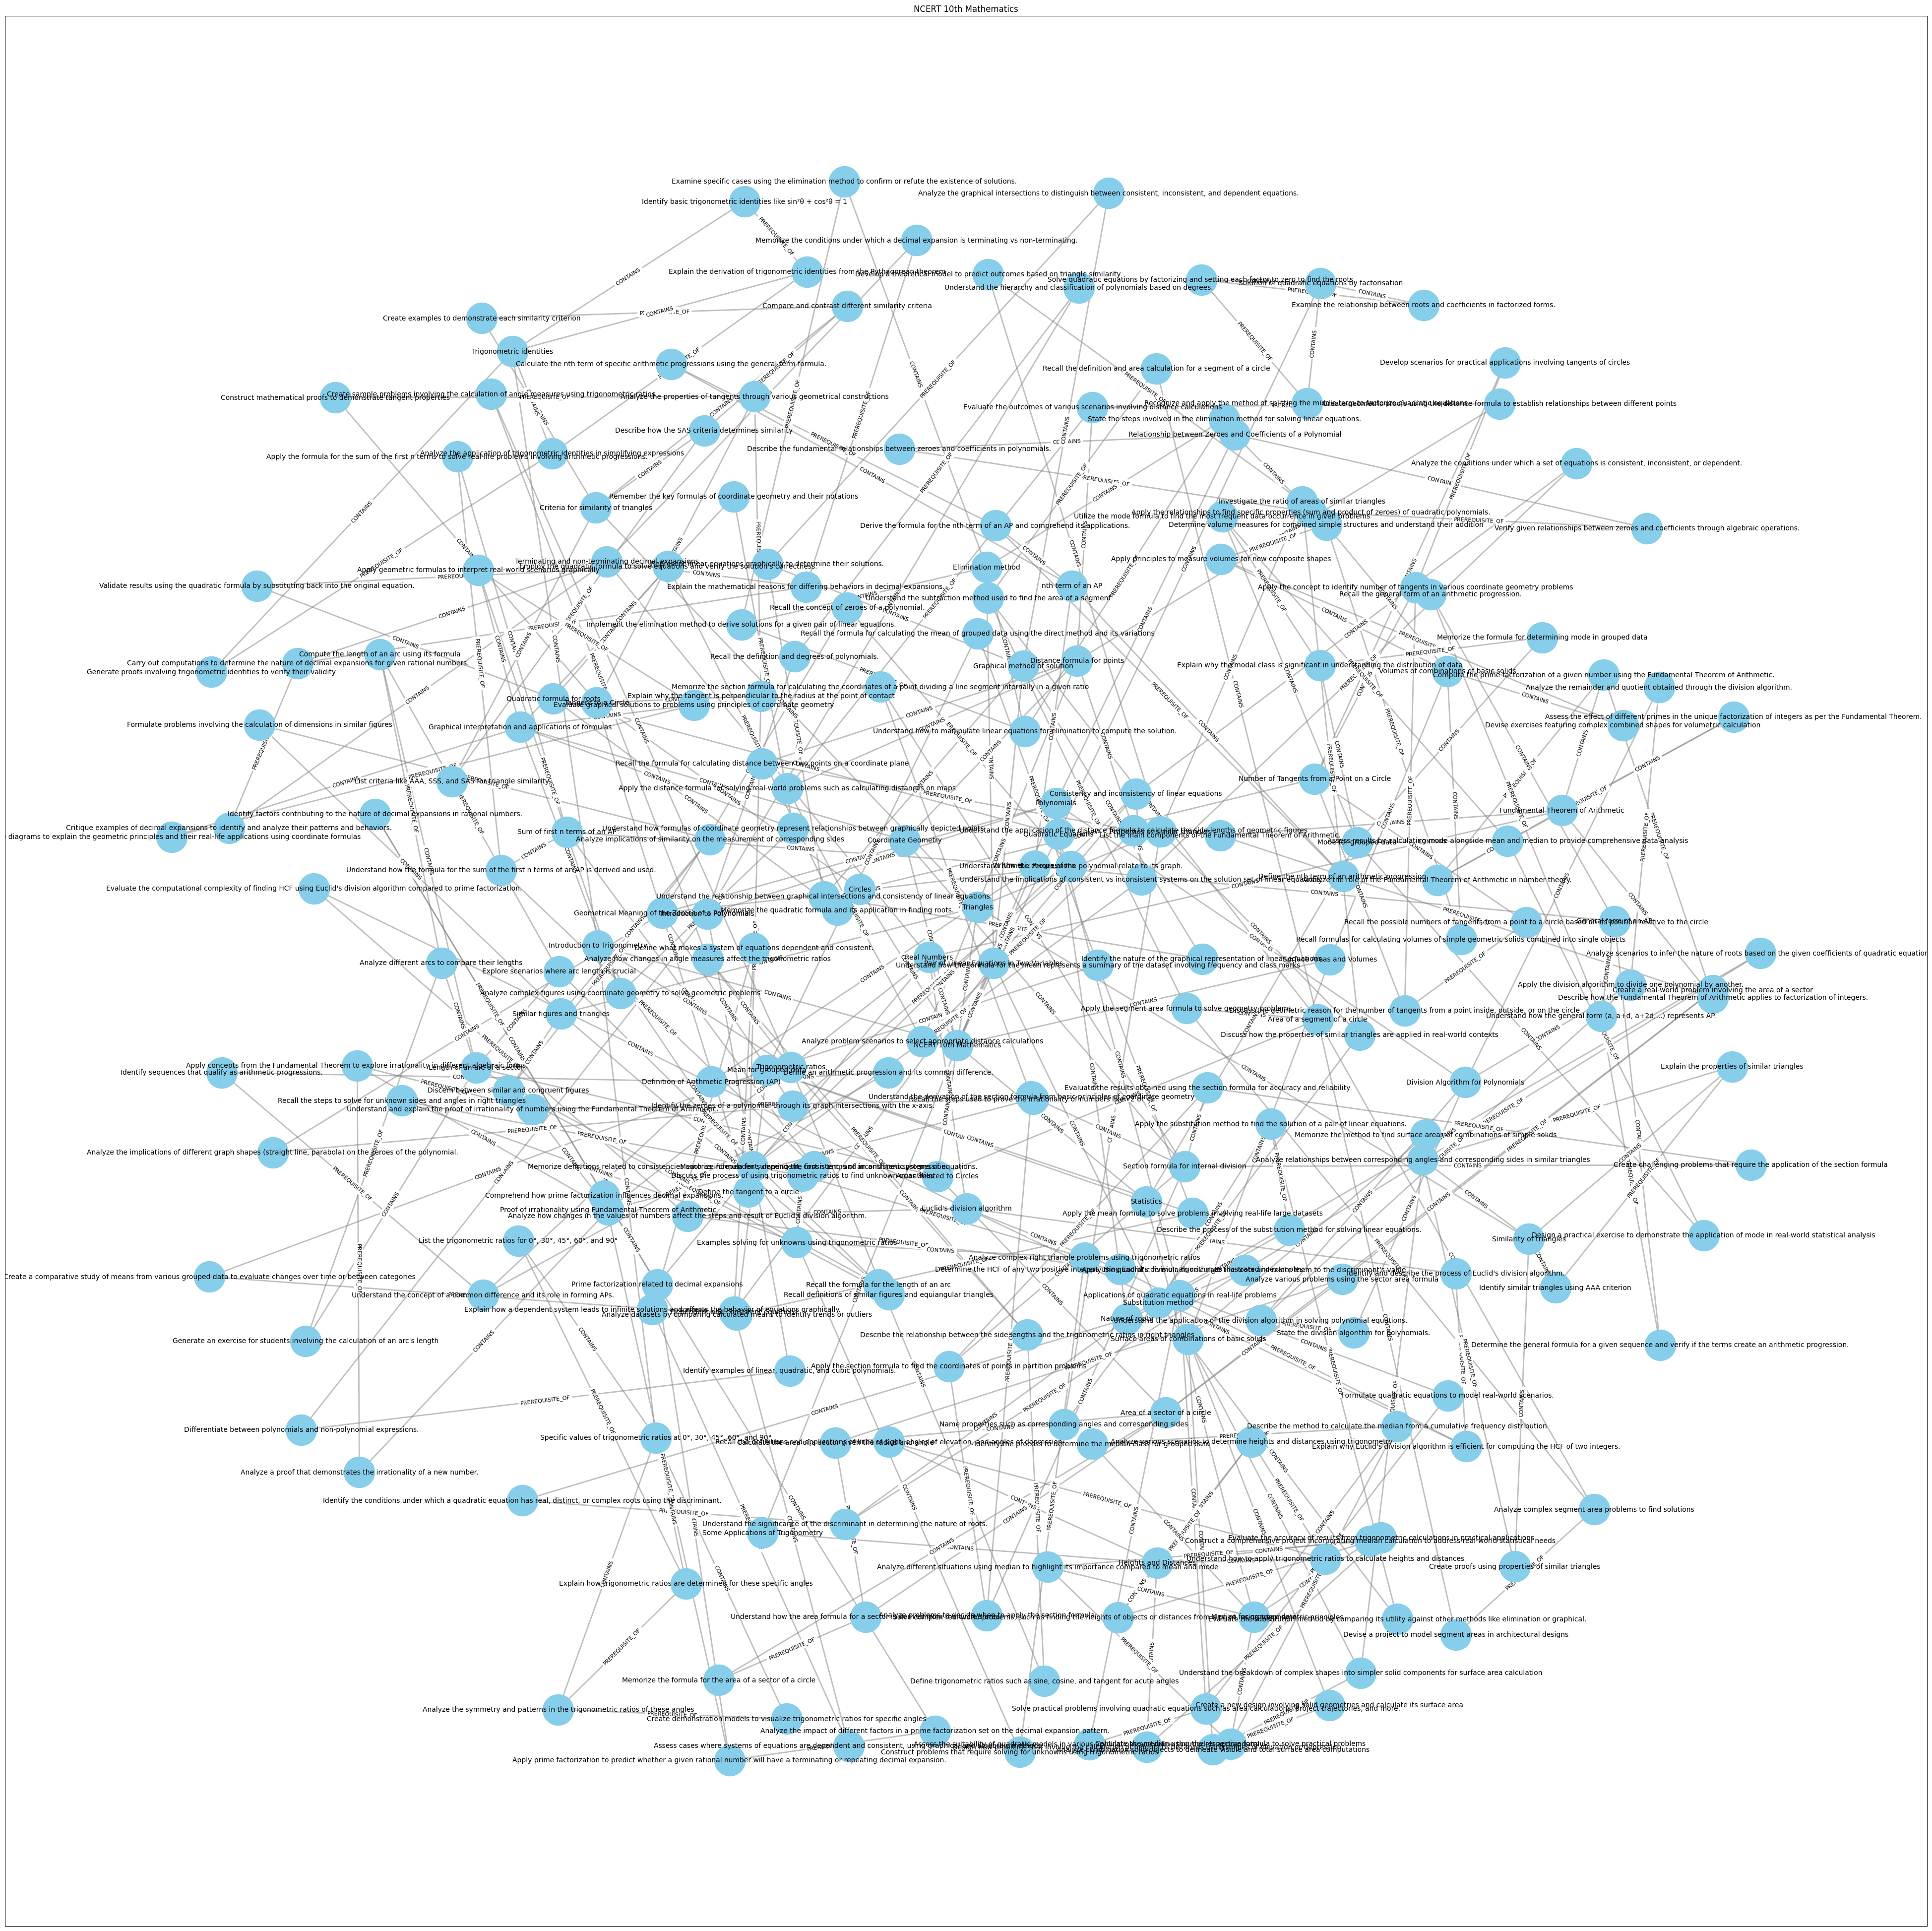

In [191]:
cypher_query = """
MATCH (n)-[r]->(m)
RETURN n.name AS source, m.name AS target, type(r) AS relationship
"""
data = graph.run(cypher_query).data()


G = nx.DiGraph()

for record in data:
    G.add_edge(record['source'], record['target'], label=record['relationship'])

# Draw the NetworkX graph
plt.figure(figsize=(50, 50))
pos = nx.spring_layout(G, k=0.3, iterations=50)  # positions for all nodes

# nodes
nx.draw_networkx_nodes(G, pos, node_size=2000, node_color="skyblue")

# edges
nx.draw_networkx_edges(G, pos, width=2, alpha=0.5, edge_color='gray')

# labels
nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")

# edge labels
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

plt.title("NCERT 10th Mathematics")
plt.show()